# IMPORT

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import display
from IPython.display import HTML
# Load the multi-stream data
path_multistream = "/home/dani/trail22KD/testdir/multistream/inference_results.csv"
df_multistream = pd.read_csv(path_multistream)

# Load the data
path = "/home/dani/trail22KD/testdir/WALT-journal/inference_results.csv"
df = pd.read_csv(path)
# Convert source_domain and source_period into a tuple for easy comparison
df['source_combo'] = list(zip(df['source_domain'], df['source_period']))

# Filter for rows where the strategy is in STRATEGIES_TO_EXCLUDE and source domain is equal to target domain
MODELS = ['yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x6']
models_df = df[df['strategy'].isin(MODELS)]

# Exclude models from strategies
df_without_coco = df[~df['strategy'].isin(MODELS)]

# Filter for rows where source domain is equal to target domain
same_domain_df = df_without_coco[df_without_coco['source_domain'] == df_without_coco['target_domain']].copy()# Added .copy() to prevent SettingWithCopyWarning


<h1> <font color="blue"> 1. SCALABILITY - VALIDATION OF STRATEGIES UP TO 9 cameras </font><h1>
 

In [2]:
def generate_plot(dataframe, strategies, samples, eligible_domains_periods, df, MODELS_TO_PLOT):
    # Filter for a specific sample, strategy and the domain-period combinations
    filtered_df = dataframe[(dataframe['strategy'].isin(strategies)) & 
                            (dataframe['samples'].isin(samples)) & 
                            (dataframe['source_combo'].isin(eligible_domains_periods))]

    # Group by strategy and sample and calculate average 'mAP50-95'
    grouped_df = filtered_df.groupby(['strategy', 'samples']).mean(numeric_only=True)['mAP50-95'].reset_index()

    # Pivot to wide format for plotting
    pivot_df = grouped_df.pivot(index='samples', columns='strategy', values='mAP50-95')
    # Plot
    plt.figure(figsize=(10, 8))
    ax = plt.gca()  # get the current axes, creating them if necessary
    for column in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[column], marker='', linewidth=2, label=column)

    # Filter for rows for strategies to be plot
   
    models_to_plot_df = df[df['strategy'].isin(MODELS_TO_PLOT)]

    # Calculate average 'mAP50-95' for each strategy
    models_df_avg = models_to_plot_df.groupby('strategy').mean(numeric_only=True)['mAP50-95']
    display(models_df_avg)
    
    # For each model, add a horizontal line across the entire x-axis range
    for strategy, avg_mAP in models_df_avg.items():
        ax.hlines(avg_mAP, xmin=pivot_df.index.min(), xmax=pivot_df.index.max(), colors='black', linestyles='dotted', alpha=1, linewidth=2)  # adjust linewidth here
        # annotate the lines
        plt.text(pivot_df.index.max(), avg_mAP, f"{strategy}: {avg_mAP:.2f}", color='red', va='center', ha='left')


    # Set labels, legend, and title
    ax.legend()
    ax.set_title('Average mAP50-95 values per sample for different strategies')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Average mAP50-95')
    ax.grid(True)

    plt.show()
    return filtered_df



 <h2> <font color="blue"> 1.1. ALL ELIGIBLE CAMERAS - WEEKS - SAMPLES </font><h2>

strategy
yolov8m     0.556000
yolov8n     0.483778
yolov8x6    0.560222
Name: mAP50-95, dtype: float64

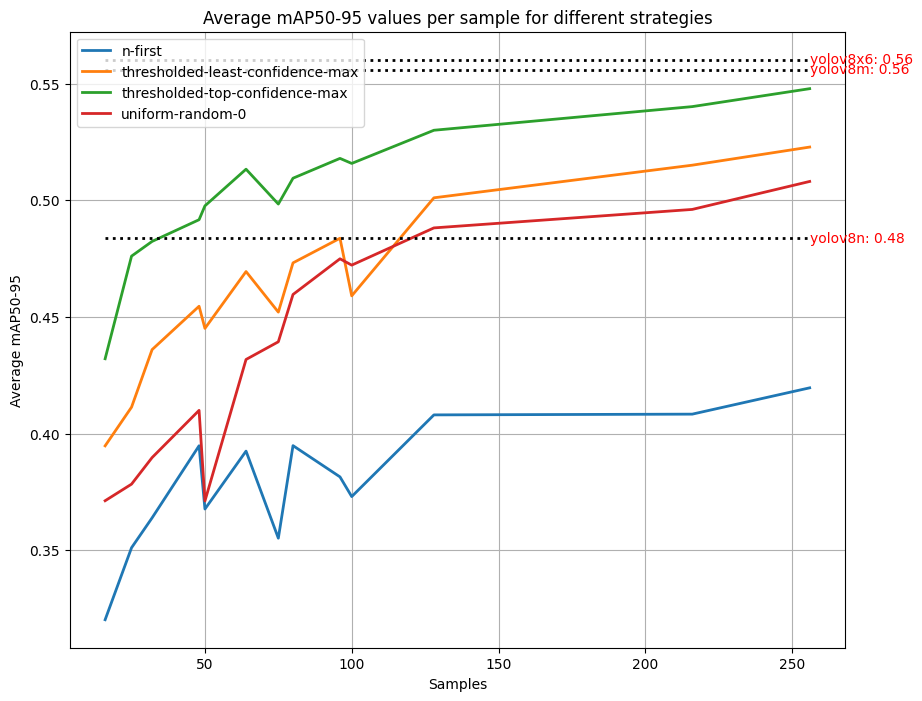

In [4]:
# Create a list of domains and periods for which we want to filter
eligible_scalability_domains_periods = [('cam1', 'week1'), ('cam1', 'week2'), ('cam1', 'week3'), ('cam1', 'week4'),
                                        ('cam2', 'week1'), ('cam2', 'week2'), ('cam2', 'week3'), ('cam2', 'week4'),
                                        ('cam3', 'week5'), 
                                        ('cam4', 'week2'), ('cam4', 'week3'), 
                                        ('cam5', 'week3'), 
                                        ('cam6', 'week1'),('cam6', 'week3'),('cam6', 'week4'), 
                                        ('cam7', 'week4'), 
                                        ('cam8', 'week3'), 
                                        ('cam9', 'week1')]

all_strategies = ['n-first','uniform-random-0','thresholded-top-confidence-max','thresholded-least-confidence-max']
all_sample_size = [16,25,32,48,50,64,75,80,96,100,128,216,256]
MODELS_TO_PLOT = ['yolov8n', 'yolov8m', 'yolov8x6']

scalable_all_samples_all_strategies_df = generate_plot(same_domain_df, all_strategies, all_sample_size, eligible_scalability_domains_periods, df, MODELS_TO_PLOT)


 <h2> <font color="blue"> 1.2. ALL ELIGIBLE CAMERAS - WEEKS - BUT SAMPLES are multiple of 16 </font><h2>

strategy
yolov8m     0.556000
yolov8n     0.483778
yolov8x6    0.560222
Name: mAP50-95, dtype: float64

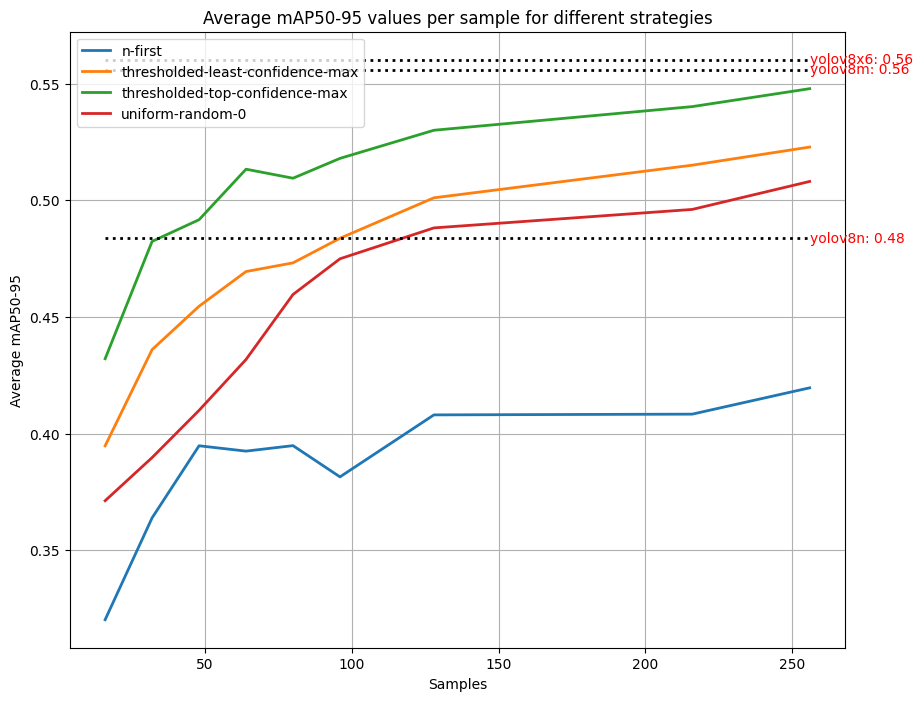

In [5]:
sixteen_multiple_sample_size = [16,32,48,64,80,96,128,216,256]


scalable_all_strategies_sixteen_multiple_samples_df=generate_plot(same_domain_df, all_strategies, sixteen_multiple_sample_size, eligible_scalability_domains_periods, df, MODELS_TO_PLOT)


<h1> <font color="blue"> 2. CLUSTERING </font><h1>


<h2> <font color="blue"> 2.1 HEATMAP </font><h2>

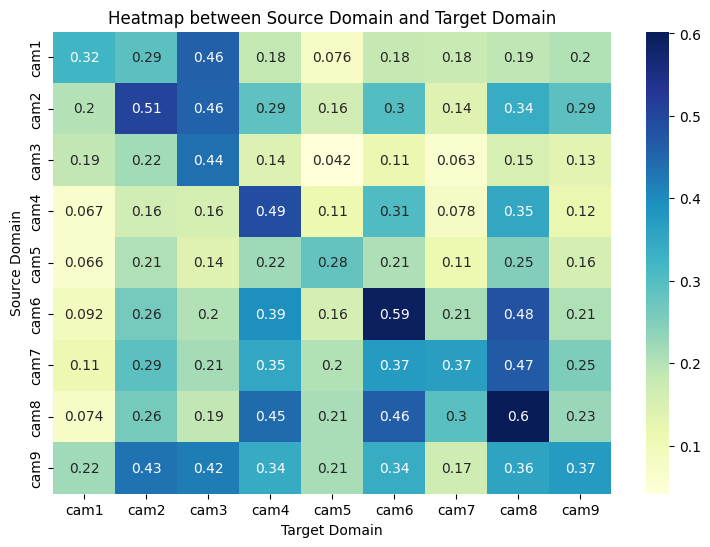

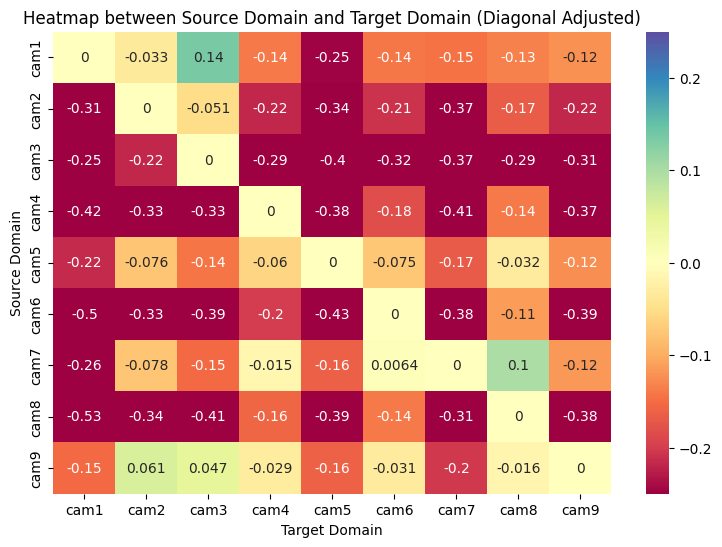

In [186]:
# Create a list of domains and periods for which we want to filter
eligible_clustering_domains_periods = [('cam1', 'week1'), ('cam1', 'week2'), ('cam1', 'week3'), ('cam1', 'week4'),
                                        ('cam2', 'week1'), ('cam2', 'week2'), ('cam2', 'week3'), ('cam2', 'week4'),
                                        ('cam3', 'week5'), 
                                        ('cam4', 'week2'), ('cam4', 'week3'), 
                                        ('cam5', 'week3'), 
                                        ('cam6', 'week1'),('cam6', 'week3'),('cam6', 'week4'), 
                                        ('cam7', 'week4'), 
                                        ('cam8', 'week3'), 
                                        ('cam9', 'week1')]

samples = [16,32,48,64,80,96,128,216,256]

eligible_clustering_df= df_without_coco[df_without_coco['source_combo'].isin(eligible_clustering_domains_periods)
                                       &(df_without_coco['samples'].isin(samples))]

grouped_df = eligible_clustering_df.groupby(['source_domain', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_domain', columns='target_domain', values='mAP50-95')

# Plotting the first heatmap (without any adjustments)
plt.figure(figsize=(9,6)) 
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap between Source Domain and Target Domain')
plt.xlabel('Target Domain')
plt.ylabel('Source Domain')
plt.show()

# Subtract diagonal value from each row
pivot_df_diag_adjusted = pivot_df.apply(lambda row: row - row[row.name], axis=1)

# Plotting the second heatmap (with diagonal adjustments)
plt.figure(figsize=(9,6)) 
sns.heatmap(pivot_df_diag_adjusted, vmin=-0.25, vmax=0.25, annot=True, cmap='Spectral')
plt.title('Heatmap between Source Domain and Target Domain (Diagonal Adjusted)')
plt.xlabel('Target Domain')
plt.ylabel('Source Domain')
plt.show()


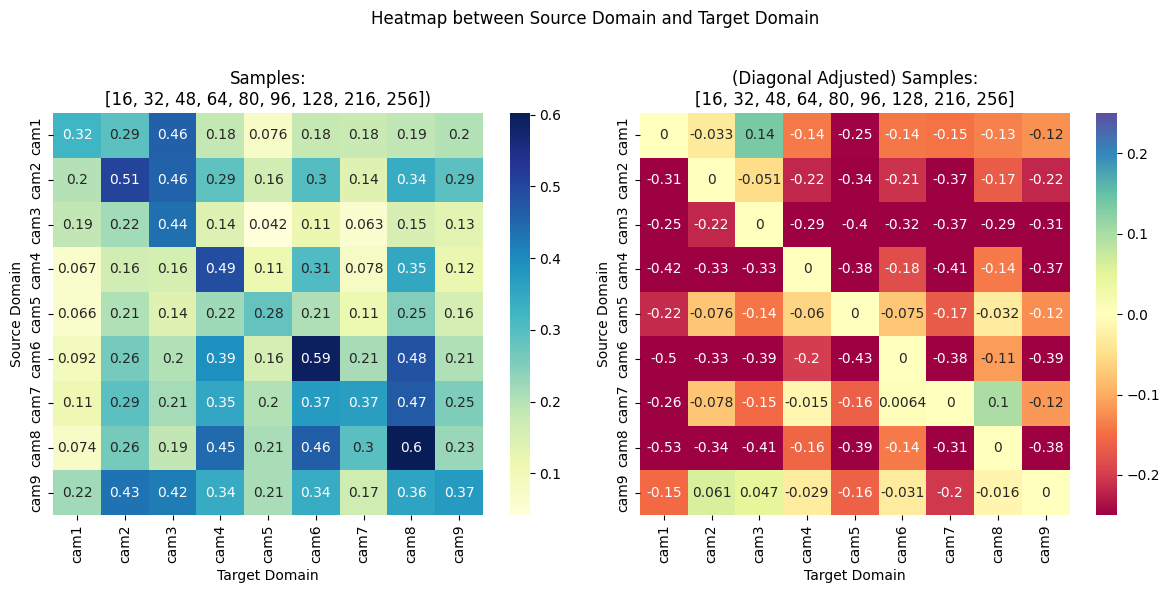

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of domains and periods for which we want to filter
eligible_clustering_domains_periods = [('cam1', 'week1'), ('cam1', 'week2'), ('cam1', 'week3'), ('cam1', 'week4'),
                                        ('cam2', 'week1'), ('cam2', 'week2'), ('cam2', 'week3'), ('cam2', 'week4'),
                                        ('cam3', 'week5'), 
                                        ('cam4', 'week2'), ('cam4', 'week3'), 
                                        ('cam5', 'week3'), 
                                        ('cam6', 'week1'),('cam6', 'week3'),('cam6', 'week4'), 
                                        ('cam7', 'week4'), 
                                        ('cam8', 'week3'), 
                                        ('cam9', 'week1')]

samples = [16,32,48,64,80,96,128,216,256]

eligible_clustering_df= df_without_coco[df_without_coco['source_combo'].isin(eligible_clustering_domains_periods)
                                       &(df_without_coco['samples'].isin(samples))]

grouped_df = eligible_clustering_df.groupby(['source_domain', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_domain', columns='target_domain', values='mAP50-95')

# Create a 1x2 subplot grid (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set the title for the whole figure
fig.suptitle('Heatmap between Source Domain and Target Domain')

# Plotting the first heatmap (without any adjustments) on the first subplot
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Samples:\n{})'.format(samples))
axes[0].set_xlabel('Target Domain')
axes[0].set_ylabel('Source Domain')

# Subtract diagonal value from each row
pivot_df_diag_adjusted = pivot_df.apply(lambda row: row - row[row.name], axis=1)

# Plotting the second heatmap (with diagonal adjustments) on the second subplot
sns.heatmap(pivot_df_diag_adjusted, vmin=-0.25, vmax=0.25, annot=True, cmap='Spectral', ax=axes[1])
axes[1].set_title('(Diagonal Adjusted) Samples:\n{}'.format(samples))
axes[1].set_xlabel('Target Domain')
axes[1].set_ylabel('Source Domain')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusts the padding between the subplots and the title
plt.show()



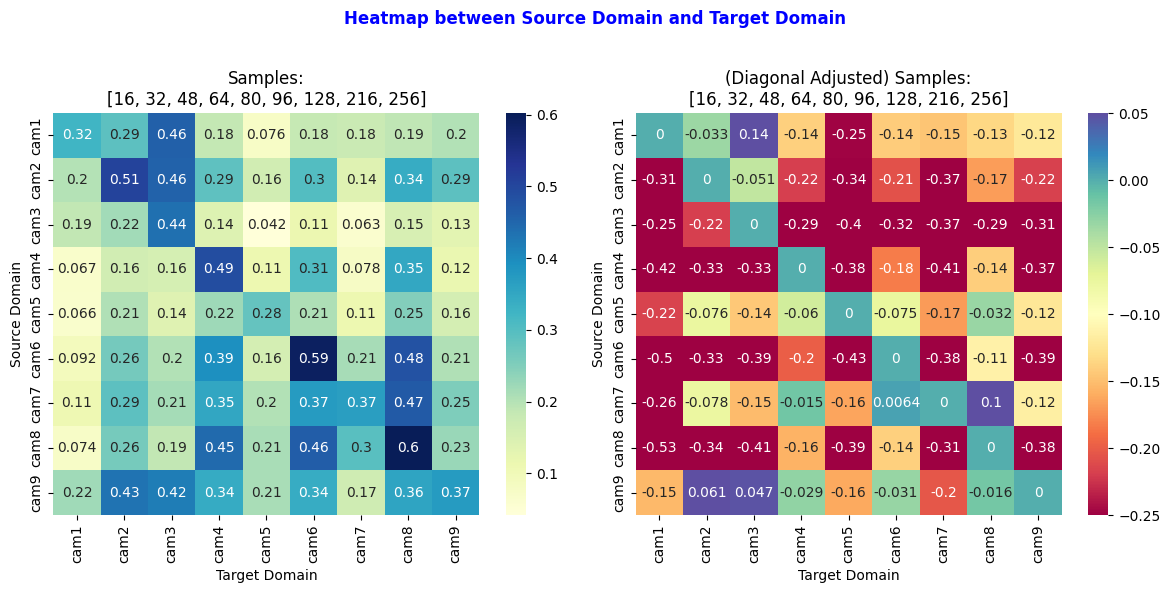

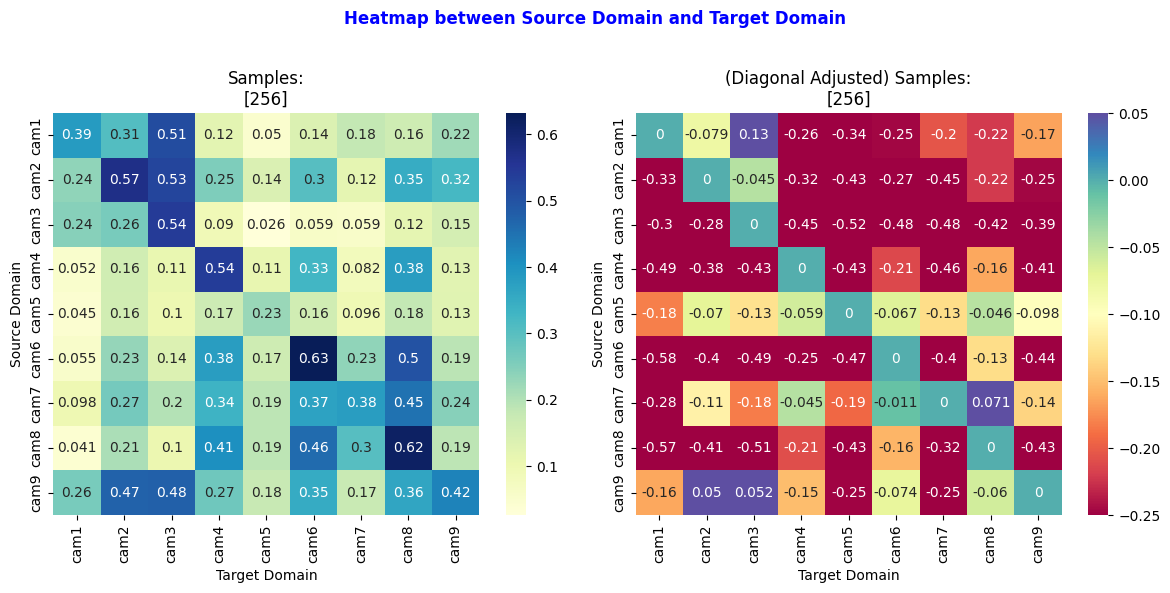

In [188]:
# Function to plot heatmap
def plot_heatmap(samples):
    # Create a list of domains and periods for which we want to filter
    eligible_clustering_domains_periods = [('cam1', 'week1'), ('cam1', 'week2'), ('cam1', 'week3'), ('cam1', 'week4'),
                                            ('cam2', 'week1'), ('cam2', 'week2'), ('cam2', 'week3'), ('cam2', 'week4'),
                                            ('cam3', 'week5'), 
                                            ('cam4', 'week2'), ('cam4', 'week3'), 
                                            ('cam5', 'week3'), 
                                            ('cam6', 'week1'),('cam6', 'week3'),('cam6', 'week4'), 
                                            ('cam7', 'week4'), 
                                            ('cam8', 'week3'), 
                                            ('cam9', 'week1')]
    
    eligible_clustering_df= df_without_coco[df_without_coco['source_combo'].isin(eligible_clustering_domains_periods)
                                           &(df_without_coco['samples'].isin(samples))]

    grouped_df = eligible_clustering_df.groupby(['source_domain', 'target_domain'], as_index=False)['mAP50-95'].mean()

    # Now pivot the grouped DataFrame
    pivot_df = grouped_df.pivot(index='source_domain', columns='target_domain', values='mAP50-95')

    # Create a 1x2 subplot grid (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Set the title for the whole figure
    fig.suptitle('Heatmap between Source Domain and Target Domain', weight='bold', color='blue')

    # Plotting the first heatmap (without any adjustments) on the first subplot
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', ax=axes[0])
    axes[0].set_title('Samples:\n{}'.format(samples))
    axes[0].set_xlabel('Target Domain')
    axes[0].set_ylabel('Source Domain')

    # Subtract diagonal value from each row
    pivot_df_diag_adjusted = pivot_df.apply(lambda row: row - row[row.name], axis=1)

    # Plotting the second heatmap (with diagonal adjustments) on the second subplot
    sns.heatmap(pivot_df_diag_adjusted, vmin=-0.25, vmax=0.05, annot=True, cmap='Spectral', ax=axes[1])
    axes[1].set_title('(Diagonal Adjusted) Samples:\n{}'.format(samples))
    axes[1].set_xlabel('Target Domain')
    axes[1].set_ylabel('Source Domain')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusts the padding between the subplots and the title
    plt.show()

# Test the function with different samples
samples_list = [[16,32,48,64,80,96,128,216,256], [256]]
for samples in samples_list:
    plot_heatmap(samples)


<h2> <font color="blue"> 2.2 Hiearchichal Clustering </font><h2>


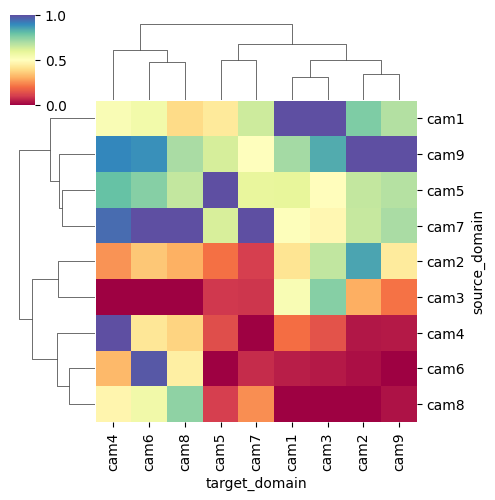

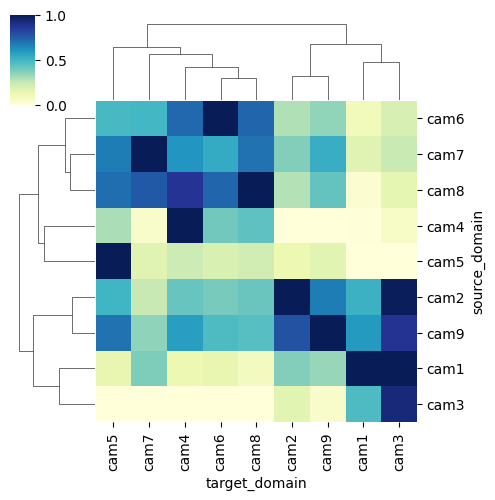

In [196]:
# Create the clustermap plots
grid_adjusted = sns.clustermap(pivot_df_diag_adjusted, cmap='Spectral', standard_scale=1, figsize=(5, 5))
grid = sns.clustermap(pivot_df, cmap='YlGnBu', standard_scale=1, figsize=(5, 5))

<h2> <font color="blue"> 2.3 Definition of the clustering </font><h2>

In [11]:
from scipy.cluster.hierarchy import fcluster

# Set a distance threshold for cluster assignment
# (this should be adjusted based on the distances in your dendrogram)
threshold = 1.0

# Get the linkage matrix for the rows
row_linkage = grid.dendrogram_row.linkage

# Assign each row to a cluster
row_clusters = fcluster(row_linkage, threshold, criterion='distance')

# Get the linkage matrix for the columns
col_linkage = grid.dendrogram_col.linkage

# Assign each column to a cluster
col_clusters = fcluster(col_linkage, threshold, criterion='distance')

print(col_clusters)
# Now row_clusters and col_clusters contain the cluster assignments for the rows and columns, respectively



[4 3 4 1 2 1 1 1 3]


The application of different thresholds leads to a varying number of clusters as follows:

- **Threshold = 1.2:**   
  With this threshold, we get **2 clusters**:
    - **Cluster 1:** Contains cameras 1, 2, 3, and 9
    - **Cluster 2:** Contains cameras 4, 5, 6, 7, and 8

- **Threshold = 1.05:**  
  With this threshold, we get **3 clusters**:
    - **Cluster 1:** Contains cameras 4, 5, 6, 7, and 8
    - **Cluster 2:** Contains cameras 1 and 3
    - **Cluster 3:** Contains cameras 2 and 9

- **Threshold = 1:**   
  With this threshold, we get **4 clusters**:
    - **Cluster 1:** Contains cameras 4, 6, 7, and 8
    - **Cluster 2:** Contains cameras 1 and 3
    - **Cluster 3:** Contains cameras 2 and 9
    - **Cluster 4:** Contains camera 5

- **Threshold < 1:**  
  With a threshold less than 1, we get **5 clusters**:
    - **Cluster 1:** Contains cameras 4, 6, and 8
    - **Cluster 2:** Contains camera 7
    - **Cluster 3:** Contains cameras 2 and 9
    - **Cluster 4:** Contains camera 5
    - **Cluster 5:** Contains cameras 1 and 9

The choice of the threshold should be based on domain knowledge and the specific use case.


In [92]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

def calculate_clusters(linkage_matrix, min_threshold, max_threshold, step):
    first_occurrences = {}
    seen_clusters = set()

    for threshold in np.arange(min_threshold, max_threshold, step):
        clusters = fcluster(linkage_matrix, threshold, criterion='distance')
        num_clusters = len(np.unique(clusters))
        
        if num_clusters not in seen_clusters:
            seen_clusters.add(num_clusters)
            first_occurrences[num_clusters] = {'threshold': threshold, 'clusters': []}
            
            for cluster_num in range(1, num_clusters + 1):
                indices = np.where(clusters == cluster_num)[0] + 1 # Increment indices by 1
                first_occurrences[num_clusters]['clusters'].append(indices)
    return first_occurrences

# Get the linkage matrix for the rows
row_linkage = grid.dendrogram_row.linkage
row_clusters = calculate_clusters(row_linkage, 0.5, 1.5, 0.05)

row_linkage_adjusted = grid_adjusted.dendrogram_row.linkage
row_clusters_adjusted = calculate_clusters(row_linkage_adjusted, 0.5, 1.5, 0.05)

# Function to format the threshold with two decimal places
def format_threshold(threshold):
    return "{:.2f}".format(threshold)

# Set the maximum number of num_clusters to display
max_num_clusters_to_display = 4

# Get the sorted unique num_clusters
sorted_num_clusters = sorted(set(row_clusters.keys()).union(set(row_clusters_adjusted.keys())))

# Limit the number of num_clusters to display
num_clusters_to_display = sorted_num_clusters[:max_num_clusters_to_display]

# Iterate through clusters and print results side by side for the selected num_clusters
for num_clusters in num_clusters_to_display:
    # Grid 1
    if num_clusters in row_clusters:
        print('Grid 1:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Grid 1: No clusters found at this threshold.')
        
    print('\t\t\t')

    # Grid 2
    if num_clusters in row_clusters_adjusted:
        print('Adjusted Grid:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_adjusted[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_adjusted[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Adjusted Grid: No clusters found at this threshold.')
    
    print('\n')


Grid 1:
2 clusters at threshold 1.35:
Cluster 1: [4 5 6 7 8]
Cluster 2: [1 2 3 9]
			
Adjusted Grid:
2 clusters at threshold 1.40:
Cluster 1: [1 5 7 9]
Cluster 2: [2 3 4 6 8]


Grid 1:
3 clusters at threshold 1.25:
Cluster 1: [4 5 6 7 8]
Cluster 2: [2 9]
Cluster 3: [1 3]
			
Adjusted Grid:
3 clusters at threshold 1.00:
Cluster 1: [1 5 7 9]
Cluster 2: [2 3]
Cluster 3: [4 6 8]


Grid 1:
4 clusters at threshold 1.15:
Cluster 1: [6 7 8]
Cluster 2: [4 5]
Cluster 3: [2 9]
Cluster 4: [1 3]
			
Adjusted Grid:
4 clusters at threshold 0.85:
Cluster 1: [5 7 9]
Cluster 2: [1]
Cluster 3: [2 3]
Cluster 4: [4 6 8]


Grid 1:
5 clusters at threshold 0.80:
Cluster 1: [6 7 8]
Cluster 2: [4]
Cluster 3: [5]
Cluster 4: [2 9]
Cluster 5: [1 3]
			
Adjusted Grid: No clusters found at this threshold.




<h1> <font color="blue"> 3. Clustering Performance Analysis </font> </h1>

In [172]:

from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
import pandas as pd
import numpy as np

def filter_data(strategy, sample_size, df, source_period=None, 
                source_domain=None, excluded_domains=None):
    filtered_df = df[(df['strategy'] == strategy) & 
                     (df['samples'] == sample_size)]
    
    if source_period is not None:
        filtered_df = filtered_df[filtered_df['source_period'] == source_period]
    
    if source_domain is not None:
        filtered_df = filtered_df[filtered_df['source_domain'] == source_domain]
    
    if excluded_domains is not None:
        filtered_df = filtered_df[~filtered_df['target_domain'].isin(excluded_domains)]
        
    return filtered_df


def perform_statistical_tests(df1, df2):
    t_statistic, p_value_t = ttest_ind(df1['mAP50-95'], df2['mAP50-95'])
    t_test_result = 'Means are statistically different (reject H0)' if p_value_t < 0.05 else 'Means statistically undifferent'
    
    _, p_shapiro_single = shapiro(df1['mAP50-95'])
    shapiro_single_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_single < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_shapiro_multi = shapiro(df2['mAP50-95'])
    shapiro_multi_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_multi < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_levene = levene(df1['mAP50-95'], df2['mAP50-95'])
    levene_result = 'Variances do not look equal (reject H0)' if p_levene < 0.05 else 'Variances look equal (fail to reject H0)'

    _, p_mannwhitney = mannwhitneyu(df1['mAP50-95'], df2['mAP50-95'])
    mannwhitney_result = 'Different distribution (reject H0)' if p_mannwhitney < 0.05 else 'Same distribution (fail to reject H0)'
    
    return t_statistic, p_value_t, t_test_result, p_shapiro_single, shapiro_single_result, p_shapiro_multi, shapiro_multi_result, p_levene, levene_result, p_mannwhitney, mannwhitney_result

def add_row_to_results(df, data):
    new_row = pd.DataFrame([data])
    return pd.concat([df, new_row], ignore_index=True)

def test_strategies(number_cluster,
                    cluster_content, selected_sample_sizes,
                    selected_strategy,
                    selected_source_domain_multi,
                    selected_source_period_multi,
                    restricted_eligible_clustering_df,
                    df_multistream,
                    excluded_domains_df,
                    included_target_domains,
                    excluded_target_domains):
    
    results = pd.DataFrame(columns=['Number Cluster', 'Cluster Content','Sample Size', 'Strategy', 
                                    'Mean Single Stream', 'Mean Multi',
                                    'T-Statistic', 'P-Value', 'T-Test Result',
                                    'Shapiro-Wilk Single Stream', 'Shapiro-Wilk Multi',
                                    'Shapiro-Wilk Single Stream Result', 'Shapiro-Wilk Multi Result',
                                    'Levene', 'Levene Result', 
                                    'Mann-Whitney U', 'Mann-Whitney U Result',
                                    'Mean Single Stream Excluded',
                                    'MEAN-MULTI_ EXCLUDED_DOMAINS',                     
                                    'T-Statistic_excl', 
                                    'P-Value_excl',
                                    'T-Test Result_excl',
                                    'Shapiro-Wilk Single Stream Excl',
                                    'Shapiro-Wilk Single Stream Result Excl',
                                    'Shapiro-Wilk Multi Excl',
                                    'Shapiro-Wilk Multi Result Excl',
                                    'Levene Excl',
                                    'Levene Result Excl',
                                    'Mann-Whitney U Excl',
                                    'Mann-Whitney U Result_excl'])
    
    for sample_size in selected_sample_sizes:
        for strategy in selected_strategy:
            one_strategy_one_sample_df = filter_data(strategy, sample_size, restricted_eligible_clustering_df)
            filtered_df_multistream = filter_data(strategy, sample_size, df_multistream, selected_source_period_multi, selected_source_domain_multi, excluded_target_domains)

            mean_single = one_strategy_one_sample_df['mAP50-95'].mean()
            mean_multi = filtered_df_multistream['mAP50-95'].mean()
            
            
            one_strategy_one_sample_df_excl = filter_data(strategy, sample_size, excluded_domains_df)
            mean_single_excluded = one_strategy_one_sample_df_excl['mAP50-95'].mean()
            filtered_df_multistream_excl = filter_data(strategy, sample_size, df_multistream, selected_source_period_multi, selected_source_domain_multi, excluded_domains=included_target_domains)
            mean_multi_excluded_domains = filtered_df_multistream_excl['mAP50-95'].mean()

            t_statistic, p_value_t, t_test_result, p_shapiro_single, shapiro_single_result, p_shapiro_multi, shapiro_multi_result, p_levene, levene_result, p_mannwhitney, mannwhitney_result = perform_statistical_tests(one_strategy_one_sample_df, filtered_df_multistream)
            t_statistic_excl, p_value_t_excl, t_test_result_excl, p_shapiro_single_excl, shapiro_single_result_excl, p_shapiro_multi_excl, shapiro_multi_result_excl, p_levene_excl, levene_result_excl, p_mannwhitney_excl, mannwhitney_result_excl = perform_statistical_tests(one_strategy_one_sample_df_excl, filtered_df_multistream_excl)
            data = {'Number Cluster': number_cluster,
                    'Cluster Content': cluster_content,
                    'Sample Size': sample_size, 
                    'Strategy': strategy, 
                    'Mean Single Stream': mean_single,
                    'Mean Multi': mean_multi,
                    'T-Statistic': t_statistic, 
                    'P-Value': p_value_t,
                    'T-Test Result': t_test_result,
                    'Shapiro-Wilk Single Stream': p_shapiro_single,
                    'Shapiro-Wilk Single Stream Result': shapiro_single_result,
                    'Shapiro-Wilk Multi': p_shapiro_multi,
                    'Shapiro-Wilk Multi Result': shapiro_multi_result,
                    'Levene': p_levene,
                    'Levene Result': levene_result,
                    'Mann-Whitney U': p_mannwhitney,
                    'Mann-Whitney U Result': mannwhitney_result,
                    'Mean Single Stream Excluded': mean_single_excluded,
                    'MEAN-MULTI_ EXCLUDED_DOMAINS': mean_multi_excluded_domains,
                    'T-Statistic_excl': t_statistic_excl, 
                    'P-Value_excl': p_value_t_excl,
                    'T-Test Result_excl': t_test_result_excl,
                    'Shapiro-Wilk Single Stream Excl': p_shapiro_single_excl,
                    'Shapiro-Wilk Single Stream Result Excl': shapiro_single_result_excl,
                    'Shapiro-Wilk Multi Excl': p_shapiro_multi_excl,
                    'Shapiro-Wilk Multi Result Excl': shapiro_multi_result_excl,
                    'Levene Excl': p_levene_excl,
                    'Levene Result Excl': levene_result_excl,
                    'Mann-Whitney U Excl': p_mannwhitney_excl,
                    'Mann-Whitney U Result_excl': mannwhitney_result_excl}
            
            results = add_row_to_results(results, data)
        
    return results



def analyze_performance(number_cluster, 
                        selected_strategy,
                        domain_periods,
                        excluded_domains_periods,
                        sample_sizes,
                        included_domains,
                        excluded_domains, 
                        source_domain, 
                        source_period):
    sixteen_multiple_sample_size = [16,32,48,64,80,96,128,216,256]
    
    restricted_eligible_clustering_df= same_domain_df[
        (same_domain_df['samples'].isin(sixteen_multiple_sample_size)) &
        same_domain_df['source_combo'].isin(domain_periods)
    ]
    excluded_domains_df= same_domain_df[
        (same_domain_df['samples'].isin(sixteen_multiple_sample_size)) &
        same_domain_df['source_combo'].isin(excluded_domains_periods)
    ]

    cluster_cameras = ", ".join([cam for cam, _ in domain_periods])

    print('Number of records:', len(restricted_eligible_clustering_df))
    print('Mean mAP50-95:', restricted_eligible_clustering_df['mAP50-95'].mean())

    results_df = test_strategies(number_cluster,
                                 cluster_cameras,
                                 sample_sizes,
                                 selected_strategy,
                                 source_domain,
                                 source_period,
                                 restricted_eligible_clustering_df,
                                 df_multistream,
                                 excluded_domains_df,
                                 included_domains,
                                 excluded_domains)
    
    return results_df



<h2> <font color="blue"> 3.1 Performance analysis of 1 cluster </font> </h2>

In [168]:
# Define common variables

selected_strategy=['uniform-random-0', 'n-first','thresholded-top-confidence-max']
selected_sample_sizes = [96, 216]

# Cluster 1
domain_periods = [('cam1', 'week1'), ('cam2', 'week1'), ('cam3', 'week5'), ('cam4', 'week2'), 
                  ('cam5','week3'),('cam6', 'week4'), ('cam7', 'week4'), ('cam8', 'week3'), ('cam9', 'week1')]
excluded_domains = []
source_domain = 'cam1e2e3e4e5e6e7e8e9'
source_period = 'week1e1e5e2e3e4e4e3e1'

print('Performance analysis of 1 cluster - CLUSTER of CAMERAS 1,2,3,4,5,6 7,8 and 9')
results_df = analyze_performance(1,
                                 selected_strategy,
                                 domain_periods, 
                                 selected_sample_sizes, 
                                 excluded_domains, 
                                 source_domain, 
                                 source_period)
display(results_df)

Performance analysis of 1 cluster - CLUSTER of CAMERAS 1,2,3,4,5,6 7,8 and 9


TypeError: analyze_performance() missing 2 required positional arguments: 'source_domain' and 'source_period'

In [169]:
# Define common variables

selected_strategy=['uniform-random-0', 'n-first','thresholded-top-confidence-max']
selected_sample_sizes = [96, 216]

# Cluster 1
included_domains = ['cam1','cam2','cam3','cam4','cam5','cam6', 'cam7','cam8', 'cam9']

domain_periods = [('cam1', 'week1'), ('cam2', 'week1'), ('cam3', 'week5'), ('cam4', 'week2'), 
                  ('cam5','week3'),('cam6', 'week4'), ('cam7', 'week4'), ('cam8', 'week3'), ('cam9', 'week1')]
excluded_domains = []
excluded_domains_periods = []
source_domain = 'cam1e2e3e4e5e6e7e8e9'
source_period = 'week1e1e5e2e3e4e4e3e1'

print('Performance analysis of 1 cluster - CLUSTER of CAMERAS 1,2,3,4,5,6 7,8 and 9')
results_df = analyze_performance(1,
                                 selected_strategy,
                                 domain_periods,
                                 excluded_domains_periods,
                                 selected_sample_sizes, 
                                 included_domains,
                                 excluded_domains, 
                                 source_domain, 
                                 source_period)
display(results_df)

Performance analysis of 1 cluster - CLUSTER of CAMERAS 1,2,3,4,5,6 7,8 and 9
Number of records: 318
Mean mAP50-95: 0.44444902445669504


,Number Cluster,Cluster Content,Sample Size,Strategy,Mean Single Stream,Mean Multi,T-Statistic,P-Value,T-Test Result,Shapiro-Wilk Single Stream,Shapiro-Wilk Multi,Shapiro-Wilk Single Stream Result,Shapiro-Wilk Multi Result,Levene,Levene Result,Mann-Whitney U,Mann-Whitney U Result,Mean Single Stream Excluded,MEAN-MULTI_ EXCLUDED_DOMAINS
0,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",96,uniform-random-0,0.467694,0.372222,1.588667,0.131698,Means statistically undifferent,0.281107,0.798078,Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),0.694409,Variances look equal (fail to reject H0),0.133120,Same distribution (fail to reject H0),NaN,NaN
1,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",96,n-first,0.351641,0.412556,-0.902334,0.380263,Means statistically undifferent,0.459872,0.986038,Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),0.473076,Variances look equal (fail to reject H0),0.479929,Same distribution (fail to reject H0),NaN,NaN
2,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",96,thresholded-top-confidence-max,0.501547,0.480222,0.375969,0.711878,Means statistically undifferent,0.006595,0.543044,Sample does not look Gaussian (reject H0),Sample looks Gaussian (fail to reject H0),0.919443,Variances look equal (fail to reject H0),0.426777,Same distribution (fail to reject H0),NaN,NaN
3,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",216,uniform-random-0,0.471902,0.424778,0.638040,0.532474,Means statistically undifferent,0.002512,0.943403,Sample does not look Gaussian (reject H0),Sample looks Gaussian (fail to reject H0),0.770790,Variances look equal (fail to reject H0),0.216373,Same distribution (fail to reject H0),NaN,NaN
4,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",216,n-first,0.382863,0.423000,-0.605068,0.553620,Means statistically undifferent,0.025584,0.995310,Sample does not look Gaussian (reject H0),Sample looks Gaussian (fail to reject H0),0.975876,Variances look equal (fail to reject H0),0.894572,Same distribution (fail to reject H0),NaN,NaN
5,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",216,thresholded-top-confidence-max,0.530031,0.488333,0.704460,0.491274,Means statistically undifferent,0.010781,0.092342,Sample does not look Gaussian (reject H0),Sample looks Gaussian (fail to reject H0),0.605406,Variances look equal (fail to reject H0),0.376732,Same distribution (fail to reject H0),NaN,NaN


<h2> <font color="blue"> 3.2 Performance analysis of 2 cluster - CLUSTER of CAMERAS 1,2,3 and 9 </font> </h2>

In [179]:
# Cluster 2
included_domains= ['cam1','cam2','cam3','cam9']
domain_periods = [('cam1', 'week1'), ('cam2', 'week1'), ('cam3', 'week5'), ('cam9', 'week1')]
excluded_domains= ['cam4', 'cam5', 'cam6', 'cam7', 'cam8']
excluded_domains_periods = [('cam4', 'week2'), ('cam5','week3'),('cam6', 'week4'), 
                    ('cam7', 'week4'), ('cam8', 'week3')] 

source_domain = 'cam1e2e3e9'
source_period = 'week1e1e5e1'

print('Performance analysis of 2 cluster - CLUSTER of CAMERAS 1,2,3 and 9')
results_df = analyze_performance(2,
                                 selected_strategy,
                                 domain_periods,
                                 excluded_domains_periods,
                                 selected_sample_sizes,
                                 included_domains,
                                 excluded_domains, 
                                 source_domain, 
                                 source_period)
display(results_df[['Number Cluster', 
                 'Cluster Content',
                 'Sample Size', 
                 'Strategy',       
                 'Mean Single Stream', 
                 'Mean Multi',
                'T-Test Result',                           
                'Mean Single Stream Excluded',
                'MEAN-MULTI_ EXCLUDED_DOMAINS',                     
                 'T-Statistic_excl', 
                 'P-Value_excl',
                 'T-Test Result_excl',
                  'Shapiro-Wilk Single Stream Result Excl',
                   'Shapiro-Wilk Multi Result Excl',
                'Levene Result Excl',
                                    'Mann-Whitney U Result_excl']])

# Cluster 2
included_domains=['cam4','cam5','cam6','cam7','cam8']
domain_periods = [('cam4', 'week2'), ('cam5','week3'),('cam6', 'week4'), ('cam7', 'week4'), ('cam8', 'week3')]
excluded_domains= ['cam1','cam2','cam3','cam9']
excluded_domains_periods = [('cam1', 'week1'), ('cam2', 'week1'), ('cam3', 'week5'), ('cam9', 'week1')]
source_domain = 'cam4e5e6e7e8'
source_period = 'week2e3e4e4e3'

print('Performance analysis of 2 cluster - CLUSTER of CAMERAS 4,5,6 7 and 8')
results_df = analyze_performance(2,
                                 selected_strategy,
                                 domain_periods,
                                 excluded_domains_periods,
                                 selected_sample_sizes,
                                 included_domains,
                                 excluded_domains, 
                                 source_domain, 
                                 source_period)
display(results_df[['Number Cluster', 
                 'Cluster Content',
                 'Sample Size', 
                 'Strategy',       
                 'Mean Single Stream', 
                 'Mean Multi',
                'T-Test Result',                           
                'Mean Single Stream Excluded',
                'MEAN-MULTI_ EXCLUDED_DOMAINS',                     
                 'T-Statistic_excl', 
                 'P-Value_excl',
                 'T-Test Result_excl',
                  'Shapiro-Wilk Single Stream Result Excl',
                   'Shapiro-Wilk Multi Result Excl',
                'Levene Result Excl',
                                    'Mann-Whitney U Result_excl']])

Performance analysis of 2 cluster - CLUSTER of CAMERAS 1,2,3 and 9
Number of records: 144
Mean mAP50-95: 0.41903926396913727


,Number Cluster,Cluster Content,Sample Size,Strategy,Mean Single Stream,Mean Multi,T-Test Result,Mean Single Stream Excluded,MEAN-MULTI_ EXCLUDED_DOMAINS,T-Statistic_excl,P-Value_excl,T-Test Result_excl,Shapiro-Wilk Single Stream Result Excl,Shapiro-Wilk Multi Result Excl,Levene Result Excl,Mann-Whitney U Result_excl
0,2,"cam1, cam2, cam3, cam9",96,uniform-random-0,0.464750,0.38900,Means statistically undifferent,0.470049,0.1964,3.523098,0.007810,Means are statistically different (reject H0),Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Different distribution (reject H0)
1,2,"cam1, cam2, cam3, cam9",96,n-first,0.348500,0.43800,Means statistically undifferent,0.354153,0.2478,0.988127,0.352030,Means statistically undifferent,Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Same distribution (fail to reject H0)
2,2,"cam1, cam2, cam3, cam9",96,thresholded-top-confidence-max,0.491281,0.48125,Means statistically undifferent,0.509760,0.3324,2.279011,0.052152,Means statistically undifferent,Sample does not look Gaussian (reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Same distribution (fail to reject H0)
3,2,"cam1, cam2, cam3, cam9",216,uniform-random-0,0.518250,0.45850,Means statistically undifferent,0.434823,0.2082,1.997738,0.080799,Means statistically undifferent,Sample does not look Gaussian (reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Same distribution (fail to reject H0)
4,2,"cam1, cam2, cam3, cam9",216,n-first,0.409250,0.46600,Means statistically undifferent,0.361753,0.2218,1.300558,0.229621,Means statistically undifferent,Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Same distribution (fail to reject H0)
5,2,"cam1, cam2, cam3, cam9",216,thresholded-top-confidence-max,0.521500,0.50750,Means statistically undifferent,0.536856,0.3256,2.732612,0.025742,Means are statistically different (reject H0),Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Same distribution (fail to reject H0)


Performance analysis of 2 cluster - CLUSTER of CAMERAS 4,5,6 7 and 8
Number of records: 174
Mean mAP50-95: 0.4654777917567427


,Number Cluster,Cluster Content,Sample Size,Strategy,Mean Single Stream,Mean Multi,T-Test Result,Mean Single Stream Excluded,MEAN-MULTI_ EXCLUDED_DOMAINS,T-Statistic_excl,P-Value_excl,T-Test Result_excl,Shapiro-Wilk Single Stream Result Excl,Shapiro-Wilk Multi Result Excl,Levene Result Excl,Mann-Whitney U Result_excl
0,2,"cam4, cam5, cam6, cam7, cam8",96,uniform-random-0,0.470049,0.425100,Means statistically undifferent,0.464750,0.213656,3.802424,0.008942,Means are statistically different (reject H0),Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Different distribution (reject H0)
1,2,"cam4, cam5, cam6, cam7, cam8",96,n-first,0.354153,0.335965,Means statistically undifferent,0.348500,0.215360,1.773452,0.126518,Means statistically undifferent,Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Same distribution (fail to reject H0)
2,2,"cam4, cam5, cam6, cam7, cam8",96,thresholded-top-confidence-max,0.509760,0.490144,Means statistically undifferent,0.491281,0.236001,3.268629,0.017063,Means are statistically different (reject H0),Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Different distribution (reject H0)
3,2,"cam4, cam5, cam6, cam7, cam8",216,uniform-random-0,0.434823,0.446860,Means statistically undifferent,0.518250,0.204088,4.348256,0.004832,Means are statistically different (reject H0),Sample does not look Gaussian (reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Different distribution (reject H0)
4,2,"cam4, cam5, cam6, cam7, cam8",216,n-first,0.361753,0.390404,Means statistically undifferent,0.409250,0.180254,3.346771,0.015481,Means are statistically different (reject H0),Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances look equal (fail to reject H0),Different distribution (reject H0)
5,2,"cam4, cam5, cam6, cam7, cam8",216,thresholded-top-confidence-max,0.536856,0.527122,Means statistically undifferent,0.521500,0.164497,4.098430,0.006369,Means are statistically different (reject H0),Sample looks Gaussian (fail to reject H0),Sample looks Gaussian (fail to reject H0),Variances do not look equal (reject H0),Different distribution (reject H0)


<h2> <font color="blue"> 3.4 Counter-Analysis of - CLUSTER of CAMERAS 1 and 3 vs CAM1 and 2 </font> </h2>

In [16]:
# Create a list of domains and periods for which we want to filter
restricted_clustering_domains_periods = [('cam1', 'week1'), ('cam3', 'week5')]

sixteen_multiple_sample_size = [16,32,48,64,80,96,128,216,256]
restricted_eligible_clustering_df= same_domain_df[(same_domain_df['samples'].isin(sixteen_multiple_sample_size)) &
                                                  same_domain_df['source_combo'].isin(restricted_clustering_domains_periods)]

# Print the resulting DataFrame
filtered_single = restricted_eligible_clustering_df[(restricted_eligible_clustering_df['strategy'] == 'random-0')&
                                                   (restricted_eligible_clustering_df['samples']==96)]

#print(filtered_single[['source_domain','target_domain', 'samples','strategy','mAP50-95']])
# Filter for a certain strategy, sample size and source domain
selected_strategy = 'uniform-random'
selected_source_domain = 'cam1e3'
selected_source_period = 'week1e5'
excluded_target_domains = ['cam2', 'cam4','cam5', 'cam6', 'cam7', 'cam8','cam8','cam9']


filtered_df_multistream = df_multistream[
    (df_multistream['strategy'] == selected_strategy) & 
    (df_multistream['samples'] == 96) &
    (df_multistream['source_period'] == selected_source_period) &
    (df_multistream['source_domain'] == selected_source_domain) &
    (~df_multistream['target_domain'].isin(excluded_target_domains))  # Exclude the specified target domains
]


# Print all the mAP50-95 of all the target domains (excluding the specified domains) for the selected strategy, sample size, and source domain
print(filtered_df_multistream[['source_domain','target_domain', 'samples','strategy','mAP50-95']])





# Create a list of domains and periods for which we want to filter
restricted_clustering_domains_periods = [('cam1', 'week1'), ('cam2', 'week1')]

sixteen_multiple_sample_size = [16,32,48,64,80,96,128,216,256]
restricted_eligible_clustering_df= same_domain_df[(same_domain_df['samples'].isin(sixteen_multiple_sample_size)) &
                                                  same_domain_df['source_combo'].isin(restricted_clustering_domains_periods)]


# Print the resulting DataFrame



filtered_single = restricted_eligible_clustering_df[(restricted_eligible_clustering_df['strategy'] == 'random-0')&
                                                   (restricted_eligible_clustering_df['samples']==96)]

print(filtered_single[['source_domain','target_domain', 'samples','strategy','mAP50-95']])
# Filter for a certain strategy, sample size and source domain
selected_strategy = 'uniform-random'
selected_source_domain = 'cam1e2'
selected_source_period = 'week1e1'
excluded_target_domains = ['cam3', 'cam4','cam5', 'cam6', 'cam7', 'cam8','cam9']


filtered_df_multistream = df_multistream[
    (df_multistream['strategy'] == selected_strategy) & 
    (df_multistream['samples'] == 96) &
    (df_multistream['source_period'] == selected_source_period) &
    (df_multistream['source_domain'] == selected_source_domain) &
    (~df_multistream['target_domain'].isin(excluded_target_domains))  # Exclude the specified target domains
]


# Print all the mAP50-95 of all the target domains (excluding the specified domains) for the selected strategy, sample size, and source domain
#print(filtered_df_multistream[['source_domain','target_domain', 'samples','strategy','mAP50-95']])

# Function to apply the styling based on the gain value
def color_gain(value):
    if value < 0:
        color = '\033[31m'  # Red color ANSI escape code
    else:
        color = '\033[34m'  # Blue color ANSI escape code
    return color

# Display the title in bold blue
print('\033[34m\033[1mCounter-Analysis of - CLUSTER of CAMERAS 1 and 3 vs CAM1 and 2\033[0m')

# Calculate and display the gains and balance for CAM1, CAM2, CAM3
cam1_gain = 0.3389 - 0.394
cam3_gain = 0.521315 - 0.503
balance_1_3 = cam1_gain + cam3_gain

# Format the numbers to a maximum of 3 decimal places
cam1_gain = format(cam1_gain, ".3f")
cam3_gain = format(cam3_gain, ".3f")
balance_1_3 = format(balance_1_3, ".3f")

# Display the results for CAM1 and CAM3 with color styling
print(f"CAM1 Negative gain from multi: {color_gain(float(cam1_gain))}{cam1_gain}\033[0m")
print(f"CAM3 Positive gain from multi: {color_gain(float(cam3_gain))}{cam3_gain}\033[0m")
print("Balance:", balance_1_3)

# Calculate and display the gains and balance for CAM1 and CAM2
cam1_gain = 0.341 - 0.394
cam2_gain = 0.469 - 0.548
balance_1_2 = cam1_gain + cam2_gain

# Format the numbers to a maximum of 3 decimal places
cam1_gain = format(cam1_gain, ".3f")
cam2_gain = format(cam2_gain, ".3f")
balance_1_2 = format(balance_1_2, ".3f")

# Display the results for CAM1 and CAM2 with color styling
print(f"CAM1 Negative gain from multi: {color_gain(float(cam1_gain))}{cam1_gain}\033[0m")
print(f"CAM2 Negative gain from multi: {color_gain(float(cam2_gain))}{cam2_gain}\033[0m")
print("Balance:", balance_1_2)




    source_domain target_domain  samples        strategy  mAP50-95
378        cam1e3          cam1       96  uniform-random  0.338913
380        cam1e3          cam3       96  uniform-random  0.521315
     source_domain target_domain  samples  strategy  mAP50-95
829           cam2          cam2       96  random-0     0.548
1656          cam1          cam1       96  random-0     0.394
Counter-Analysis of - CLUSTER of CAMERAS 1 and 3 vs CAM1 and 2
CAM1 Negative gain from multi: -0.055
CAM3 Positive gain from multi: 0.018
Balance: -0.037
CAM1 Negative gain from multi: -0.053
CAM2 Negative gain from multi: -0.079
Balance: -0.132


<h2> <font color="blue"> 3.5 Performance analysis of 3 cluster - CLUSTER of CAMERAS 2 and 9 </font> </h2>

In [22]:
# Cluster 3
domain_periods = [('cam1', 'week1'), ('cam3', 'week5')]
excluded_domains = ['cam2', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8', 'cam9']
source_domain = 'cam1e3'
source_period = 'week1e5'

print('Performance analysis of 3 cluster - CLUSTER of CAMERAS 1 and 3')
results_df = analyze_performance(3,
                                 selected_strategy,
                                 domain_periods, selected_sample_sizes, excluded_domains, source_domain, source_period)
#display(results_df)

# Cluster 3
domain_periods = [('cam2', 'week1'), ('cam9', 'week2')]
excluded_domains = ['cam1', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8', 'cam3']
source_domain = 'cam2e9'
source_period = 'week1e1'

print('Performance analysis of 3 cluster - CLUSTER of CAMERAS 2 and 9')
results_df = analyze_performance(3,selected_strategy,
                                 domain_periods, selected_sample_sizes, excluded_domains, source_domain, source_period)
#display(results_df)

Performance analysis of 3 cluster - CLUSTER of CAMERAS 1 and 3
Number of records: 72
Mean mAP50-95: 0.39139061709171796
Performance analysis of 3 cluster - CLUSTER of CAMERAS 2 and 9
Number of records: 72
Mean mAP50-95: 0.44163235529100103


/home/dani/anaconda3/envs/trail22kd/lib/python3.10/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom


In [24]:
# Create an empty DataFrame for final results
final_results_df = pd.DataFrame()

# Define common variables
selected_strategy_multi = ['uniform-random-0', 'n-first','thresholhed-top-confidence-max']
selected_sample_sizes = [96, 216]

# Define clusters
clusters = [
    {
        'number': 1,
        'domain_periods': [('cam1', 'week1'), ('cam2', 'week1'), ('cam3', 'week5'), ('cam4', 'week2'), 
                           ('cam5','week3'),('cam6', 'week4'), ('cam7', 'week4'), ('cam8', 'week3'), ('cam9', 'week1')],
        'excluded_domains': [],
        'source_domain': 'cam1e2e3e4e5e6e7e8e9',
        'source_period': 'week1e1e5e2e3e4e4e3e1'
    },
    {
        'number': 2,
        'domain_periods': [('cam1', 'week1'), ('cam2', 'week1'), ('cam3', 'week5'), ('cam9', 'week1')],
        'excluded_domains': ['cam4', 'cam5', 'cam6', 'cam7', 'cam8'],
        'source_domain': 'cam1e2e3e9',
        'source_period': 'week1e1e5e1'
    },
    {
        'number': 2,
        'domain_periods': [('cam4', 'week2'), ('cam5','week3'),('cam6', 'week4'), ('cam7', 'week4'), ('cam8', 'week3')],
        'excluded_domains': ['cam1', 'cam2', 'cam3', 'cam9'],
        'source_domain': 'cam4e5e6e7e8',
        'source_period': 'week2e3e4e4e3'
    },
    {
        'number': 3,
        'domain_periods': [('cam1', 'week1'), ('cam3', 'week5')],
        'excluded_domains': ['cam2', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8', 'cam9'],
        'source_domain': 'cam1e3',
        'source_period': 'week1e5'
    },
    {
        'number': 3,
        'domain_periods': [('cam2', 'week1'), ('cam9', 'week1')],
        'excluded_domains': ['cam1', 'cam3', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8'],
        'source_domain': 'cam2e9',
        'source_period': 'week1e1'
    },
]

# Analyze each cluster and append the results to the final dataframe
for cluster in clusters:
    print(f'Performance analysis of cluster {cluster["number"]} - CLUSTER of CAMERAS {", ".join([cam for cam, _ in cluster["domain_periods"]])}')
    results_df = analyze_performance(cluster["number"], 
                                     selected_strategy, 
                                     cluster["domain_periods"], 
                                     selected_sample_sizes, 
                                     cluster["excluded_domains"], 
                                     cluster["source_domain"], 
                                     cluster["source_period"])
    final_results_df = pd.concat([final_results_df, results_df])

# Display the final results
#display(final_results_df)


Performance analysis of cluster 1 - CLUSTER of CAMERAS cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8, cam9
Number of records: 318
Mean mAP50-95: 0.44444902445669504
Performance analysis of cluster 2 - CLUSTER of CAMERAS cam1, cam2, cam3, cam9
Number of records: 144
Mean mAP50-95: 0.41903926396913727
Performance analysis of cluster 2 - CLUSTER of CAMERAS cam4, cam5, cam6, cam7, cam8
Number of records: 174
Mean mAP50-95: 0.4654777917567427
Performance analysis of cluster 3 - CLUSTER of CAMERAS cam1, cam3
Number of records: 72
Mean mAP50-95: 0.39139061709171796
Performance analysis of cluster 3 - CLUSTER of CAMERAS cam2, cam9
Number of records: 72
Mean mAP50-95: 0.4466879108465566


/home/dani/anaconda3/envs/trail22kd/lib/python3.10/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom


In [27]:
# Define the column names to display
display_columns = ['Number Cluster', 'Cluster Content', 'Mean Single Stream', 'Mean Multi', 'T-Test Result']


def highlight_rows(s):
    styles = [''] * len(s)
    for i, (mean_multi, mean_single) in enumerate(zip(s['Mean Multi'], s['Mean Single Stream'])):
        if mean_multi > mean_single:
            styles[i] = 'color: red'
    return styles

# Now, loop over unique strategies and sample sizes
for strategy in selected_strategy:
    for sample in selected_sample_sizes:
        strategy_sample_df = final_results_df[(final_results_df['Strategy'] == strategy) & (final_results_df['Sample Size'] == sample)]
        
        # If DataFrame is not empty, display it
        if not strategy_sample_df.empty:
            # Print title in blue with HTML tags
            display(HTML(f"<h2 style='color:blue;'><b>Strategy: {strategy}, Sample Size: {sample}</b></h2>"))
            
            # Note: use pd.set_option to format all floats to 3 decimal places
            with pd.option_context('display.float_format', '{:.3f}'.format): 
                df_to_display = strategy_sample_df[display_columns].reset_index(drop=True)
                
                # Apply row highlighter
                df_to_display.style.apply(highlight_rows, axis=1)
                
                # Display the DataFrame
                display(df_to_display)
        else:
            print(f"No data available for strategy {strategy} and sample size {sample}")


,Number Cluster,Cluster Content,Mean Single Stream,Mean Multi,T-Test Result
0,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.468,0.372,Means statistically undifferent
1,2,"cam1, cam2, cam3, cam9",0.465,0.389,Means statistically undifferent
2,2,"cam4, cam5, cam6, cam7, cam8",0.470,0.425,Means statistically undifferent
3,3,"cam1, cam3",0.449,0.430,Means statistically undifferent
4,3,"cam2, cam9",0.481,0.463,Means statistically undifferent


,Number Cluster,Cluster Content,Mean Single Stream,Mean Multi,T-Test Result
0,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.472,0.425,Means statistically undifferent
1,2,"cam1, cam2, cam3, cam9",0.518,0.459,Means statistically undifferent
2,2,"cam4, cam5, cam6, cam7, cam8",0.435,0.447,Means statistically undifferent
3,3,"cam1, cam3",0.516,0.514,Means statistically undifferent
4,3,"cam2, cam9",0.520,0.511,Means statistically undifferent


,Number Cluster,Cluster Content,Mean Single Stream,Mean Multi,T-Test Result
0,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.352,0.413,Means statistically undifferent
1,2,"cam1, cam2, cam3, cam9",0.349,0.438,Means statistically undifferent
2,2,"cam4, cam5, cam6, cam7, cam8",0.354,0.336,Means statistically undifferent
3,3,"cam1, cam3",0.271,0.437,Means statistically undifferent
4,3,"cam2, cam9",0.426,0.487,Means statistically undifferent


,Number Cluster,Cluster Content,Mean Single Stream,Mean Multi,T-Test Result
0,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.383,0.423,Means statistically undifferent
1,2,"cam1, cam2, cam3, cam9",0.409,0.466,Means statistically undifferent
2,2,"cam4, cam5, cam6, cam7, cam8",0.362,0.390,Means statistically undifferent
3,3,"cam1, cam3",0.382,0.471,Means statistically undifferent
4,3,"cam2, cam9",0.437,0.459,Means statistically undifferent


,Number Cluster,Cluster Content,Mean Single Stream,Mean Multi,T-Test Result
0,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.502,0.480,Means statistically undifferent
1,2,"cam1, cam2, cam3, cam9",0.491,0.481,Means statistically undifferent
2,2,"cam4, cam5, cam6, cam7, cam8",0.510,0.490,Means statistically undifferent
3,3,"cam1, cam3",0.484,0.493,Means statistically undifferent
4,3,"cam2, cam9",0.498,0.511,Means statistically undifferent


,Number Cluster,Cluster Content,Mean Single Stream,Mean Multi,T-Test Result
0,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.530,0.488,Means statistically undifferent
1,2,"cam1, cam2, cam3, cam9",0.521,0.507,Means statistically undifferent
2,2,"cam4, cam5, cam6, cam7, cam8",0.537,0.527,Means statistically undifferent
3,3,"cam1, cam3",0.517,0.513,Means statistically undifferent
4,3,"cam2, cam9",0.526,0.519,Means statistically undifferent


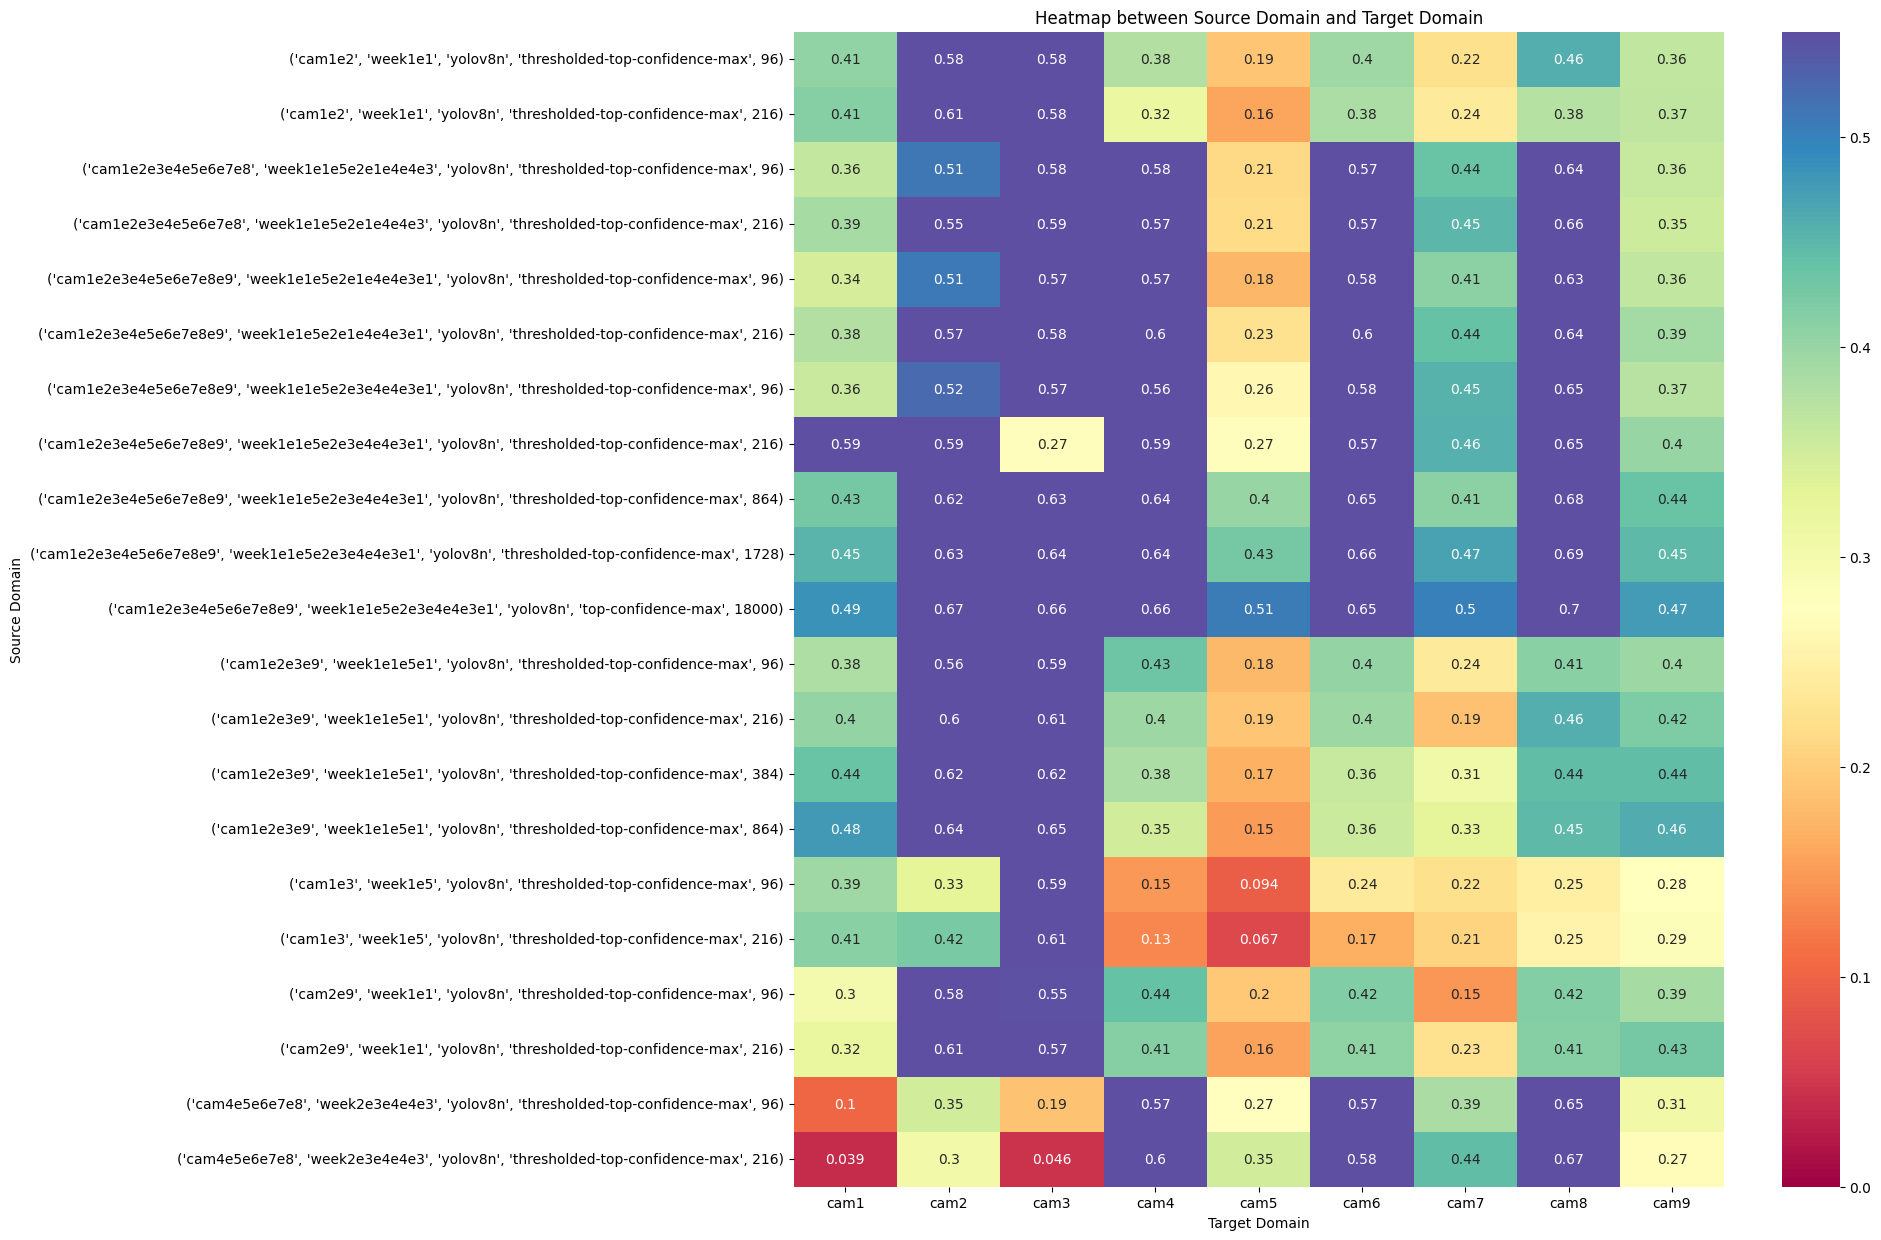

In [122]:
df_multistream['source_combo'] = list(zip(df_multistream['source_domain'], df_multistream['source_period'], df_multistream['student'], df_multistream['strategy'], df_multistream['samples']))

source_domaines=['cam1e2','cam1e3']
student=['yolov8n']
selected_strategies=['thresholded-top-confidence-max','top-confidence-max']
eligible_df_multistream = df_multistream[df_multistream['strategy'].isin(selected_strategies)&
                                         df_multistream['student'].isin(student)]
grouped_df = eligible_df_multistream.groupby(['source_combo', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_combo', columns='target_domain', values='mAP50-95')

# Plotting the first heatmap (without any adjustments)
plt.figure(figsize=(15,15)) 
sns.heatmap(pivot_df, annot=True, vmin=0, vmax=0.55, cmap='Spectral')
plt.title('Heatmap between Source Domain and Target Domain')
plt.xlabel('Target Domain')
plt.ylabel('Source Domain')
plt.show()